# Analysis

### Dataset characteristics

- Fashion-MNIST is a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. 
- It was intended to serve as a direct drop-in replacement for the original MNIST dataset (handwriten digits) for benchmarking machine learning algorithms.
- Each example is a 28x28 grayscale image, ie 784 pixel values in total, higher value meaning darker pixel. This pixel-value is an integer between 0 and 255. 
- To locate a pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27. The pixel is located on row i and column j of a 28 x 28 matrix.
- For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top.

- Each image is associated with a label from 10 classes, envenly distributed (6000 each) :

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

### Key exploration findings
- The pixels in the center of the images are on average much darker and vary less than those in the inner periphery.
- We notice that pixels on the outer periphery are almost never activated, and that the rate of activated pixels increases drastically as we approach the center of the image. 
- The distributions of the values taken for the center and inner periphery pixels are not too skewed, whereas those of the outer periphery are much more skewed, which could have a negative impact on the quality of predictions, log(1+skew) in [-2, 0.5] means skew in [-0.8647, 0.64872]. 
- Less than 50% of the pixels are activated across the dataset. 
    - It could have negative impact on predictions and algorithms performances.
    - It could be worth to experiment with cosine similarity to mitigate this result.
- 2D exploration
    - Techniques such as PCA or NMF struggle to display groups in 2D
    - TSNE achieve a good grouping in 2D but takes ages to run (I ve sample the data to run it on only 10% of the dataset size).
    - UMAP achieve a very good space splitting and run on acceptable time on the full dataset.
- 3D exploration
    - PCA seems to still struggle to split the data in groups
    - NMF achieve some better results defining regions of spaces where some classes prevail on other but still no clean cuts in the data
    - T-SNE have good results in 3D but still takes too long to run
    - UMAP achieve great results grouping the data in 4 distincts parts in decsent time
- 2D and 3D dimensionality reduction with cosine distance
    - PCA and NMF do not have the possibility to apply cosine distance
    - For T-SNE it seems to allow for better grouping distinction but still take ages to run.
    - For UMAP, it seems to define the sames groups than with euclidian distance, therefore it does not add so much value to use cosine instead of euclidian.

In [ ]:
from kagglehub import dataset_download
from pathlib import Path
import pandas as pd 
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, NMF
from umap import UMAP

FASHION_MNIST_HANDLE = 'zalando-research/fashionmnist'

data_location = dataset_download(FASHION_MNIST_HANDLE)

kaggle_data_forlder = Path(data_location)
train_data_filename = 'fashion-mnist_train.csv'

df = pd.read_csv(kaggle_data_forlder / train_data_filename)
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
df.isna().sum().sum()

np.int64(0)

No null Values

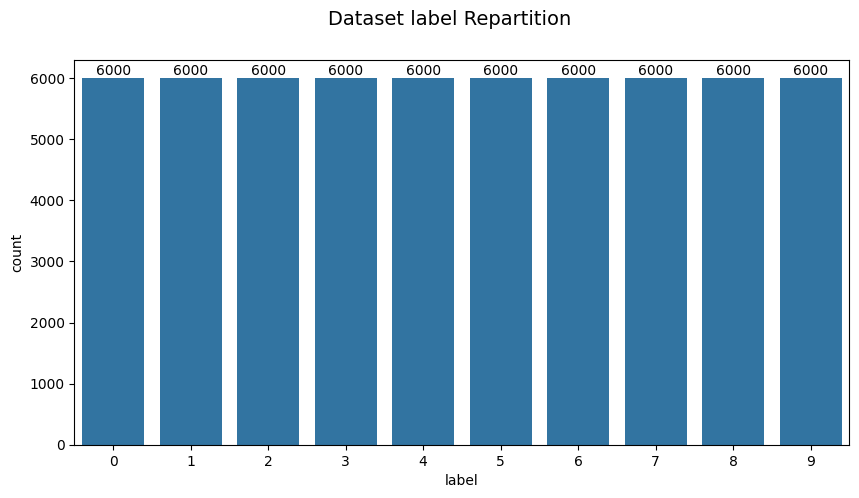

In [3]:
fig = plt.figure(figsize=(10, 5))
ax = sns.countplot(data = df, x='label')
ax.bar_label(ax.containers[0])

fig.add_axes(ax)
fig.suptitle('Dataset label Repartition', fontsize=14)
plt.show()

In [4]:
X_train = df.drop(columns='label')
y_train = df['label']

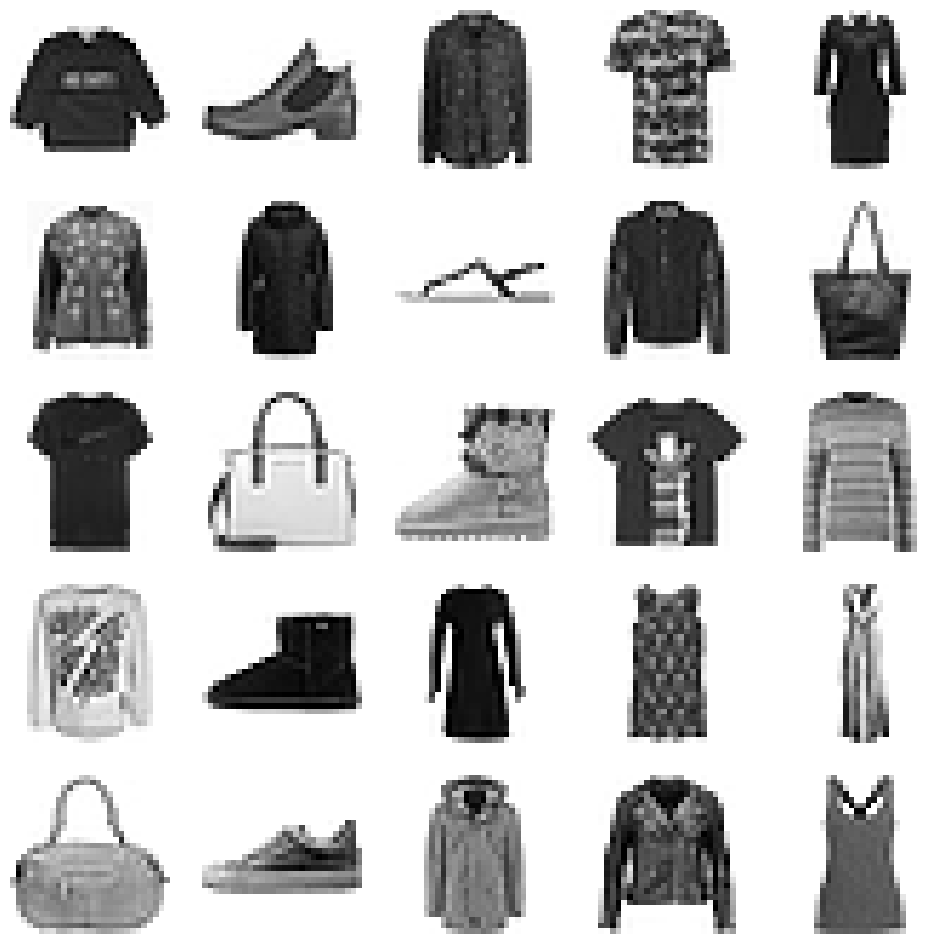

In [35]:
n_cols = 5
n_rows = 5
col_names = df.drop(columns='label').columns

fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(12, 12))
for i in range(n_rows):
    for j in range(n_cols): 
        idx = i*n_cols+j

        axs[i][j].imshow( X_train.loc[idx].values.reshape((28, 28)) , cmap='binary' )
        axs[i][j].set_axis_off()

plt.show()

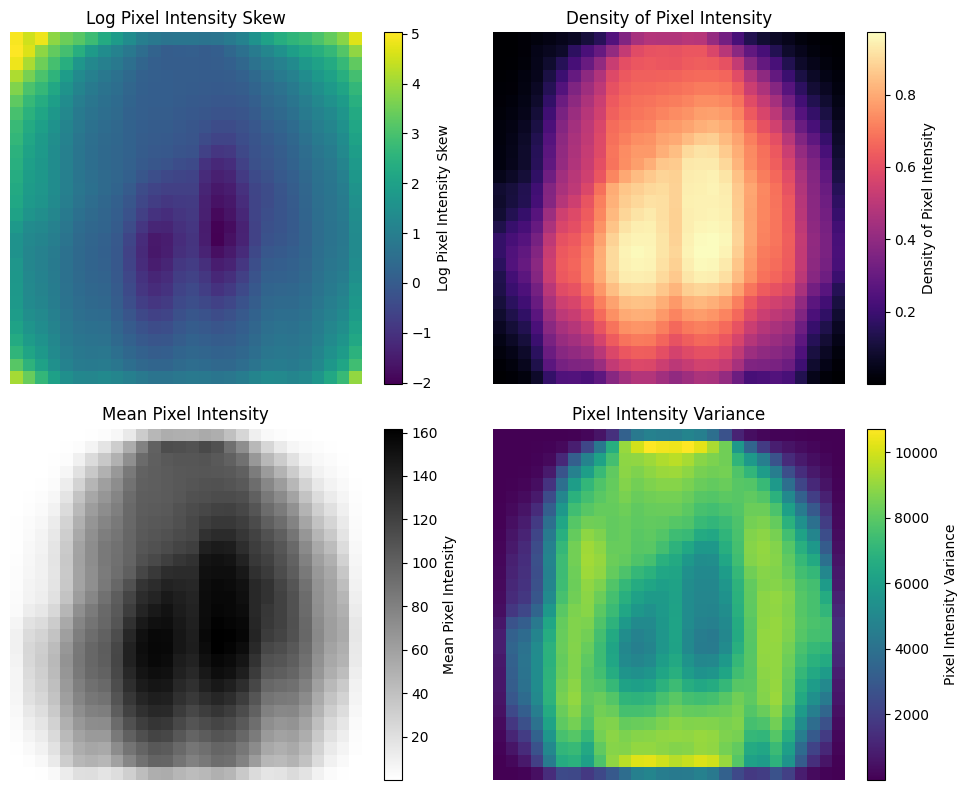

In [ ]:
X_mean = X_train.mean()
X_var = X_train.var()
X_skew = X_train.skew() 

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))

log_skew_img = axs[0][0].imshow(X_skew.apply(np.log1p).values.reshape((28, 28)))
axs[0][0].set_title('Log Pixel Intensity Skew')
axs[0][0].set_axis_off()

log_skew_cbar = fig.colorbar(log_skew_img, ax=axs[0][0], orientation='vertical')
log_skew_cbar.set_label('Log Pixel Intensity Skew')

density_img = axs[0][1].imshow(((X_train != 0).sum() / 60000).values.reshape((28, 28)), cmap='magma')
axs[0][1].set_title('Density of Pixel Intensity')
axs[0][1].set_axis_off()

density_cbar = fig.colorbar(density_img, ax=axs[0][1], orientation='vertical')
density_cbar.set_label('Density of Pixel Intensity')

mean_img = axs[1][0].imshow( X_mean.values.reshape((28, 28)), cmap='binary')
axs[1][0].set_title('Mean Pixel Intensity')
axs[1][0].set_axis_off()

mean_cbar = fig.colorbar(mean_img, ax=axs[1][0], orientation='vertical')
mean_cbar.set_label('Mean Pixel Intensity')

var_img = axs[1][1].imshow(X_var.values.reshape((28, 28)), cmap='viridis')
axs[1][1].set_title('Pixel Intensity Variance')
axs[1][1].set_axis_off()

var_cbar = fig.colorbar(var_img, ax=axs[1][1], orientation='vertical')
var_cbar.set_label('Pixel Intensity Variance')

plt.tight_layout()
plt.show()

Observations:
- The pixels in the center are on average much darker and vary less than those in the inner periphery.
- We notice that pixels on the outer periphery are almost never activated, and that the rate of activated pixels increases drastically as we approach the center of the image. 
- The distributions of the values taken for the center and inner periphery pixels are not too skewed, whereas those of the outer periphery are much more skewed, which could have a negative impact on the quality of predictions, log(1+skew) in [-2, 0.5] means skew in [-0.8647, 0.64872]. 

In [7]:
(X_train != 0).sum().sum() / (60000*784)

np.float64(0.4982011267006803)

Less than 50% of the pixels are activated across the dataset. 
- It could have negative impact on predictions and algorithms performances.
- It could be worth to experiment with cosine similarity to mitigate this result.

In [8]:
tsne_2d = TSNE(n_components=2, n_jobs=-1, random_state=42)
pca_2d = PCA(n_components=2, random_state=42)
nmf_2d = NMF(n_components=2, random_state=42)
umap_reducer_2d = UMAP(n_components=2, n_jobs=-1)

sample_rng = 4242
X_sample = X_train.sample(6000, random_state=sample_rng)
y_sample = y_train.sample(6000, random_state=sample_rng)

In [9]:
# Lets scale the data in [0, 1]

X_tsne_2d = tsne_2d.fit_transform(X_sample / 255)
X_pca_2d = pca_2d.fit_transform(X_train / 255)
X_nmf_2d = nmf_2d.fit_transform(X_train / 255)
X_umap_2d = umap_reducer_2d.fit_transform(X_train / 255)

In [10]:
def attach_scatter_2d(ax, X_transformed, labels=None, title=None, dot_size=None): 
    ax.scatter(
        X_transformed[:, 0]
        , X_transformed[:, 1]
        , c=labels
        , alpha=0.7
        , marker='.'
        , s=dot_size
    )

    ax.set_xlabel('Comp. 1')
    ax.set_ylabel('Comp. 2')

    if title is not None: 
        ax.set_title(title)


def attach_scatter_3d(ax, X_transformed, labels=None, title=None, dot_size=None): 
    ax.scatter(
        X_transformed[:, 2] 
        , X_transformed[:, 0]
        , X_transformed[:, 1]
        , c=labels
        , alpha=0.7
        , marker='.'
        , s=dot_size
    )

    ax.set_xlabel("Comp. 3")
    ax.set_ylabel("Comp. 1")
    ax.set_zlabel("Comp. 2")

    if title is not None: 
        ax.set_title(title)

    ax.view_init(azim=30)


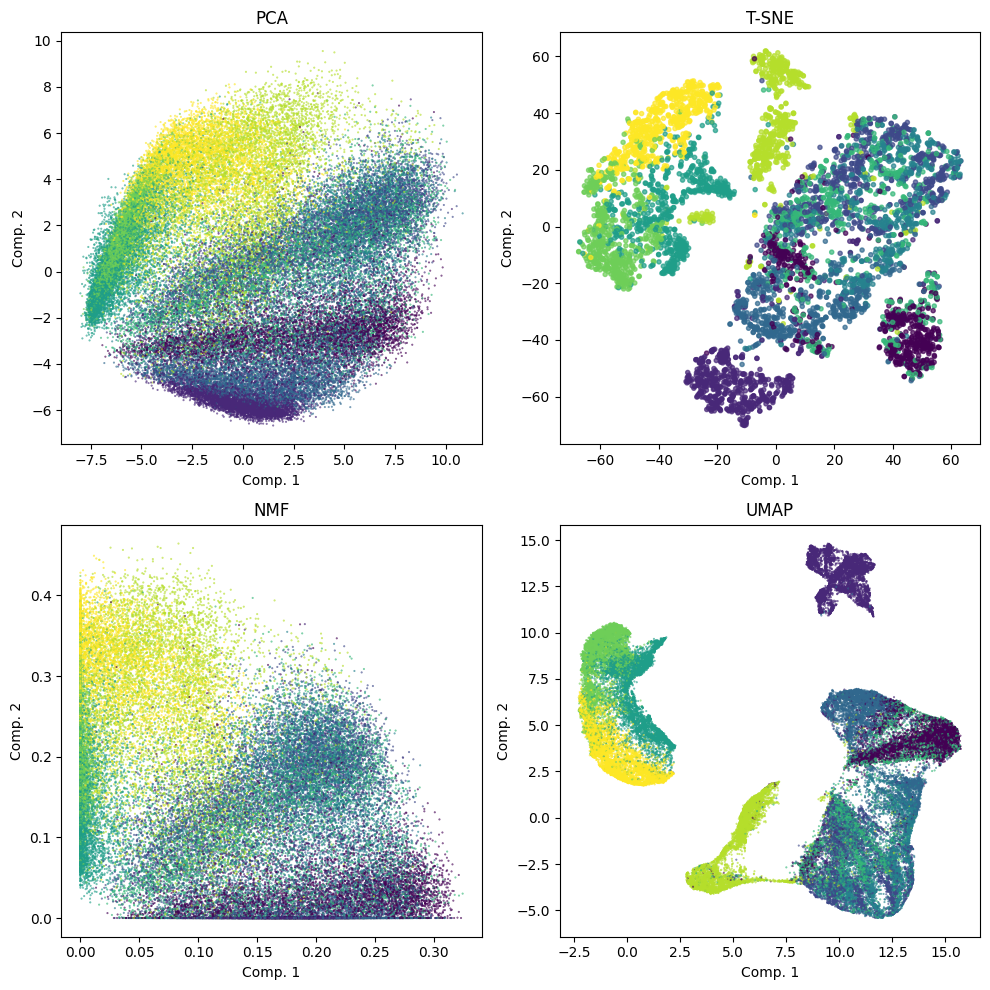

In [11]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))

attach_scatter_2d(axs[0][0], X_pca_2d, labels=y_train, title='PCA', dot_size=1)
attach_scatter_2d(axs[0][1], X_tsne_2d, labels=y_sample, title='T-SNE')
attach_scatter_2d(axs[1][0], X_nmf_2d, labels=y_train, title='NMF', dot_size=1)
attach_scatter_2d(axs[1][1], X_umap_2d, labels=y_train, title='UMAP', dot_size=1)

plt.tight_layout()
plt.show()

Observations: 
- Techniques such as PCA of NMF struggle to display groups in 2D
- TSNE achieve a good grouping in 2D but takes ages to run (I ve sample the data to run it on only 10% of the dataset size).
- UMAP achieve a very good space splitting and run on acceptable time on the full dataset.

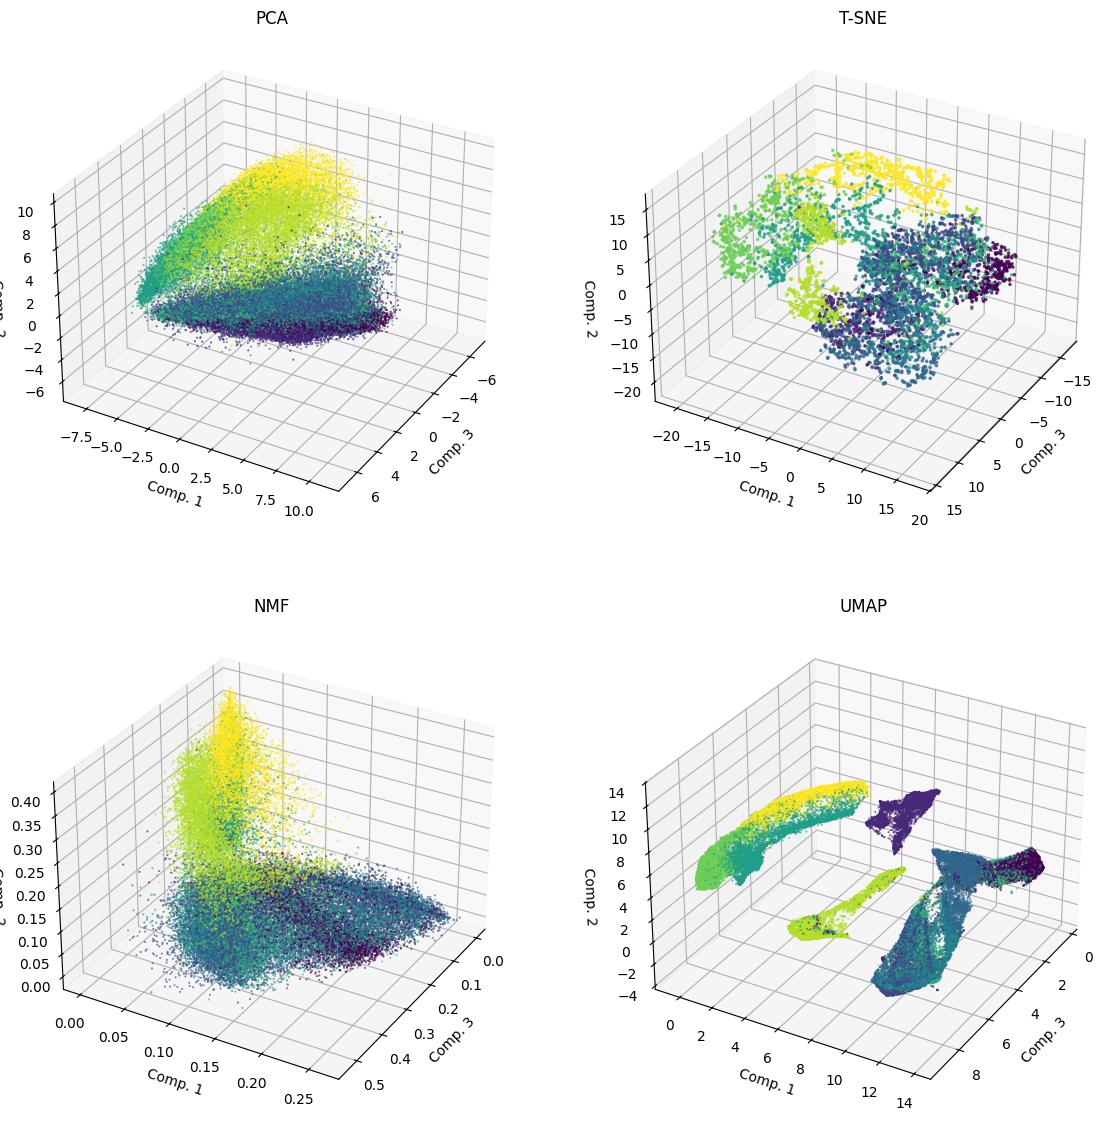

In [12]:
tsne_3d = TSNE(n_components=3, n_jobs=-1, random_state=42)
pca_3d = PCA(n_components=3, random_state=42)
nmf_3d = NMF(n_components=3, random_state=42)
umap_reducer_3d = UMAP(n_components=3, n_jobs=-1)

X_tsne_3d = tsne_3d.fit_transform(X_sample / 255)
X_pca_3d = pca_3d.fit_transform(X_train / 255)
X_nmf_3d = nmf_3d.fit_transform(X_train / 255)
X_umap_3d = umap_reducer_3d.fit_transform(X_train / 255)

fig = plt.figure(figsize=(14, 14))

ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax3 = fig.add_subplot(223, projection='3d')
ax4 = fig.add_subplot(224, projection='3d')

attach_scatter_3d(ax1, X_pca_3d, labels=y_train, title='PCA', dot_size=1)
attach_scatter_3d(ax2, X_tsne_3d, labels=y_sample, title='T-SNE', dot_size=10)
attach_scatter_3d(ax3, X_nmf_3d, labels=y_train, title='NMF', dot_size=1)
attach_scatter_3d(ax4, X_umap_3d, labels=y_train, title='UMAP', dot_size=1)

plt.show()

Observations: 
- PCA seems to still struggle to split the data in groups
- NMF achieve some better results defining regions of spaces where some classes prevail on other but still no clean cuts in the data
- T-SNE have good results in 3D but still takes too long to run
- UMAP achieve great results grouping the data in 4 distincts parts in decsent time

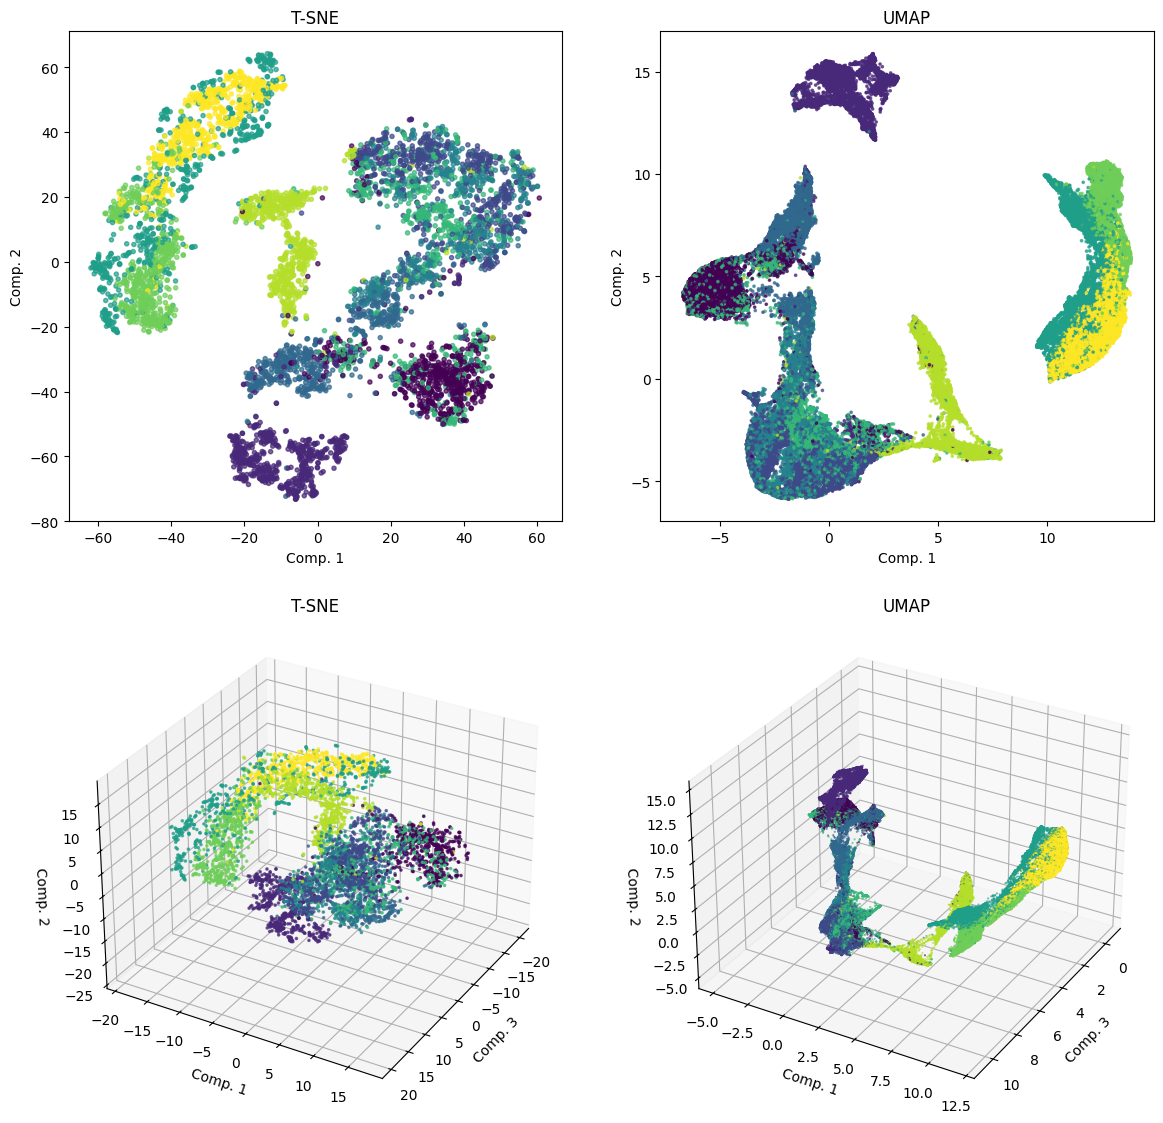

In [ ]:
tsne_2d_cosine = TSNE(n_components=2, metric='cosine', n_jobs=-1, random_state=42)
umap_reducer_2d_cosine = UMAP(n_components=2, metric='cosine', n_jobs=-1)

tsne_3d_cosine = TSNE(n_components=3, metric='cosine', n_jobs=-1, random_state=42)
umap_reducer_3d_cosine = UMAP(n_components=3, metric='cosine', n_jobs=-1)


X_tsne_2d_cosine = tsne_2d_cosine.fit_transform(X_sample / 255)
X_umap_2d_cosine = umap_reducer_2d_cosine.fit_transform(X_train / 255)

X_tsne_3d_cosine = tsne_3d_cosine.fit_transform(X_sample / 255)
X_umap_3d_cosine = umap_reducer_3d_cosine.fit_transform(X_train / 255)

fig = plt.figure(figsize=(14, 14))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223, projection='3d')
ax4 = fig.add_subplot(224, projection='3d')

attach_scatter_2d(ax1, X_tsne_2d_cosine, labels=y_sample, title='T-SNE')
attach_scatter_2d(ax2, X_umap_2d_cosine, labels=y_train, title='UMAP', dot_size=11)
attach_scatter_3d(ax3, X_tsne_3d_cosine, labels=y_sample, title='T-SNE', dot_size=10)
attach_scatter_3d(ax4, X_umap_3d_cosine, labels=y_train, title='UMAP', dot_size=1)

plt.show()

PCA and NMF do not have the possibility to apply cosine distances but I tried with T-SNE and UMAP.
- For T-SNE it seems to allow for better grouping distinction but still take ages to run.
- For UMAP, it seems to define the sames groups, therefore it does not add so much value to use cosine instead of euclidian.